In [1]:
import torch

In [2]:
checkpoint = torch.hub.load_state_dict_from_url(
    'https://api.ngc.nvidia.com/v2/models/nvidia/ssd_pyt_ckpt_amp/versions/20.06.0/files/nvidia_ssdpyt_amp_200703.pt',
    map_location=torch.device('cpu'))

In [3]:
import ssd300.model as model

ssd_model = model.SSD300()
ssd_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [4]:
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [5]:
from ssd300.processing import decode_results, pick_best
from typing import List, Dict


class Wrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        coco_idx_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                         27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51,
                         52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77,
                         78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91]

        self.coco_idx = torch.tensor(coco_idx_list)

    def forward(self, inputs: List[torch.Tensor]):
        x = ((inputs[0] * 255 - 128) / 128).unsqueeze(0)
        scale = 300.0 / min(x.shape[-2], x.shape[-1])
        x = torch.nn.functional.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=True,
                                            recompute_scale_factor=True)
        out = self.model(x)
        results = decode_results(out)
        best_results = pick_best(results[0], 0.20)
        boxes = torch.clip(best_results[0].detach(), min=0, max=1) * 300 / scale
        labels = torch.index_select(self.coco_idx, 0, (best_results[1] - 1).to(torch.int32))
        res: Dict[str, torch.Tensor] = {"boxes": boxes,
                                        "labels": labels,
                                        "scores": best_results[2]}
        return inputs, [res]

In [6]:
from torch.utils.mobile_optimizer import optimize_for_mobile

wrapped_model = Wrapper(ssd_model)

# optionally do a forward
tensor = torch.rand([3, 600, 600])
wrapped_model([tensor])

scripted_model = torch.jit.script(wrapped_model)
scripted_model.save("./model/ssd_model.pt")
# scripted_model._save_for_lite_interpreter("ssd_model.ptl")

optimized_scripted_model = optimize_for_mobile(scripted_model)
optimized_scripted_model.save("./model/optimized_ssd_model.pt")

In [14]:
# model check

ssd_model = torch.jit.load("./model/optimized_ssd_model.pt")
ssd_model.eval()

RecursiveScriptModule(original_name=Wrapper)

In [15]:
paths = [
    './data/test1.png',
    './data/test2.jpg',
    './data/test3.png'
]

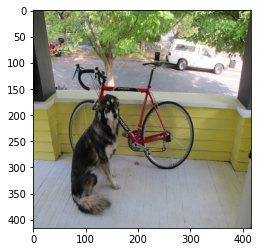

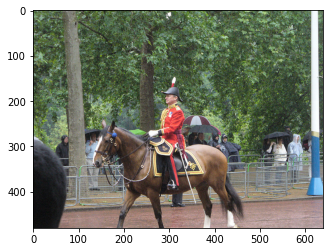

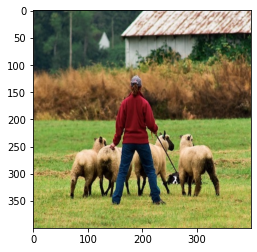

In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

imgs = []
for path in paths:
    img = Image.open(path)
    imgs.append(np.asarray(img))

for img in imgs:
    fig, ax = plt.subplots(1)
    ax.imshow(img)


In [17]:
import cv2


def normalize(img, mean=0, std=255):
    img = (img - mean) / std
    return img


def prepare_tensor(img, mean=0, std=255):
    if img.shape[2] > 3:
        img = img[:, :, :3]
    img_norm = normalize(img.astype(np.float32), mean=mean, std=std)
    img_resized = cv2.resize(img_norm, (640, 640))
    CHW = img_resized.transpose((2, 0, 1))
    tensor = torch.from_numpy(CHW)
    tensor = tensor.contiguous()
    tensor = tensor.float()
    return tensor

In [18]:
tensors = [prepare_tensor(img) for img in imgs]

In [19]:
classes_to_labels = open('./data/classes.txt').readlines()
classes_to_labels = [c.strip() for c in classes_to_labels]

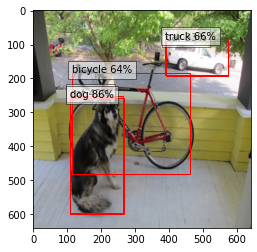

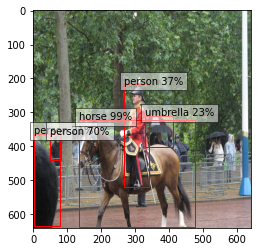

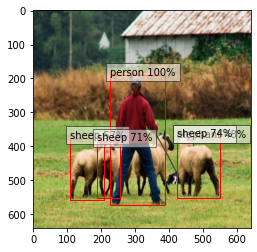

In [20]:
import matplotlib.patches as patches

for i in range(len(tensors)):
    tensor = tensors[i]
    result = ssd_model([tensor])
    fig, ax = plt.subplots(1)
    for idx in range(len(result[1][0]['scores'])):
        # Show original, denormalized image...
        ax.imshow(tensor.permute((1, 2, 0)))
        box = result[1][0]['boxes'][idx].detach().numpy()
        label = result[1][0]['labels'][idx]
        score = result[1][0]['scores'][idx]
        if score < 0.1:
            continue
        left, bot, right, top = box
        x, y, w, h = [val  for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[label - 1], score * 100),
                bbox=dict(facecolor='white', alpha=0.5))
